# Лабораторная работа №5

# Применение SSA для декомпозиции временного ряда

## Цыпаев Владимир, гр. РИМ-181228

In [2]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

## Этап разложения

In [3]:
def SSA_modes(F, L):
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K)) #траекторная матрица X
    for i in range(L):
        for j in range(K):
            X[i][j]=F[i+j]
    S = np.dot(X, X.T) #полная матрица
    U, A, _ = np.linalg.svd(S) #получение сингулярного разложения, U – матрица собственных векторов, A – массив собственных чисел
    V = np.dot(X.T, U) #матрица траекторных векторов
    return A, U, V

### Проверка функции разложения

In [4]:
ts = np.array([3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3]) # мини временной ряд
A, U, V = SSA_modes(ts, 3) # его разложение с длиной окна = 3
print("Собственные числа:\n", A, '\n') # собственные числа
print("Собственные вектора:\n", U, '\n') # собственные вектора
print("Траекторные вектора:\n", V, '\n') # траекторные вектора

Собственные числа:
 [129.66842566  12.           3.33157434] 

Собственные вектора:
 [[-5.78869570e-01  7.07106781e-01  4.06091149e-01]
 [-5.74299610e-01  4.14039445e-16 -8.18645196e-01]
 [-5.78869570e-01 -7.07106781e-01  4.06091149e-01]] 

Траекторные вектора:
 [[-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]
 [-4.03837711e+00  8.88178420e-16 -8.31570994e-01]
 [-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]
 [-4.03837711e+00  8.88178420e-16 -8.31570994e-01]
 [-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]] 



## Этап восстановления (группировки)

In [5]:
def SSA_group(A, U, V, N, I):
    L = len(A)
    K = N - L + 1
    #шаг группировки
    V_T = V.transpose()
    Z = np.dot(U[:, I], V_T[I, :])
    #диагональное усреднение
    G = np.zeros(N) #временной ряд исходной длины
    L_st = min(L, K)
    K_st = max(L, K)
    if L>K:
        Z = Z.T
    for k in range(0,L_st-1):
        for m in range(0,k+1):
            G[k]+=(1/(k+1))*Z[m,k-m]
    for k in range(L_st-1, K_st):
        for m in range(0,L_st-1):
            G[k]+=(1/(L_st-1))*Z[m,k-m]
    for k in range(K_st, N):
        for m in range(k-K_st+1,N-K_st+1):
            G[k]+=(1/(N-k))*Z[m,k-m]
    return G

### Проверка функции группировки

In [6]:
ts012 = SSA_group(A, U, V, len(ts), [0, 1, 2])
print(ts012)

[3. 2. 1. 2. 3. 2. 1. 2. 3. 2. 1. 2. 3.]


## Построение отдельных компонент тестового ряда

[2.00524905 1.83111142 1.83242368 2.16355599 2.16224373 1.83111142
 1.83242368 2.16355599 2.16224373 1.83111142 1.83242368 1.83111142
 2.00524905]


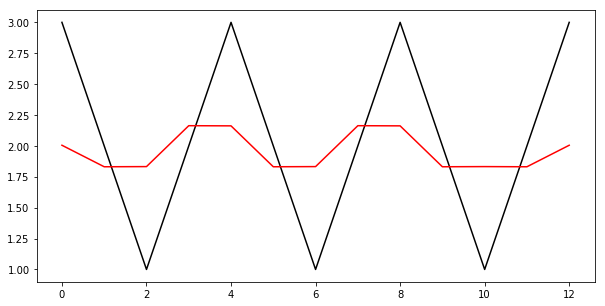

In [7]:
ts0 = SSA_group(A, U, V, len(ts), [0])
print(ts0)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts0, 'r') 
plt.show()

0-компонента содержит некоторое среднее
плавающее значение ряда (тренд)

[ 1.00000000e+00  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01 -2.92770099e-16
  1.00000000e+00]


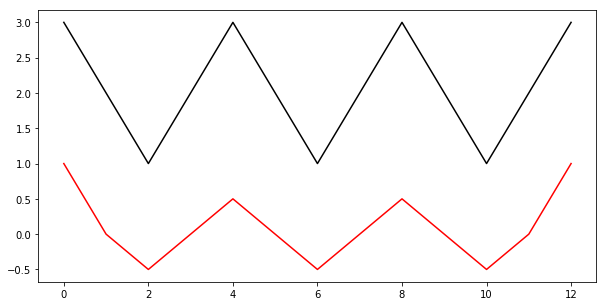

In [8]:
ts1 = SSA_group(A, U, V, len(ts), [1])
print(ts1)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts1, 'r')
plt.show()

[-0.00524905  0.16888858 -0.33242368 -0.16355599  0.33775627  0.16888858
 -0.33242368 -0.16355599  0.33775627  0.16888858 -0.33242368  0.16888858
 -0.00524905]


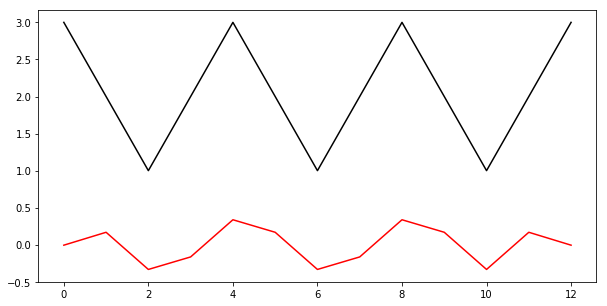

In [9]:
ts2 = SSA_group(A, U, V, len(ts), [2])
print(ts2)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts2, 'r') 
plt.show()

1-компонента и 2-компонента имеют среднее значение близкое к нулю.

1-компонента и 2-компонента имеют одинаковый период, так как любая периодическая составляющая методом SSA всегда разлагается
на парные компоненты.

Амплитуда 1-компоненты выше амплитуды 2-компоненты, так как массив собственных чисел упорядочен по убыванию, то есть с ростом номера компоненты ее «вклад» в исходный ряд уменьшается.

## Построение попарных комбинаций

[3.00524905 1.83111142 1.33242368 2.16355599 2.66224373 1.83111142
 1.33242368 2.16355599 2.66224373 1.83111142 1.33242368 1.83111142
 3.00524905]


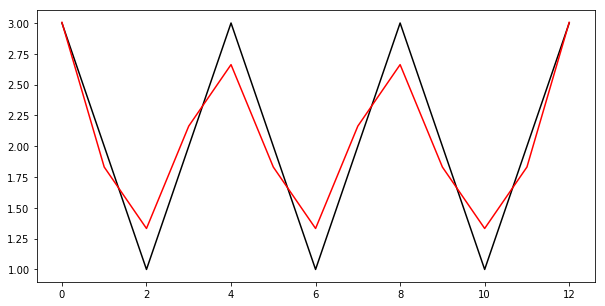

In [10]:
ts01 = SSA_group(A, U, V, len(ts), [0, 1])
print(ts01)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts01, 'r')
plt.show()

[2.  2.  1.5 2.  2.5 2.  1.5 2.  2.5 2.  1.5 2.  2. ]


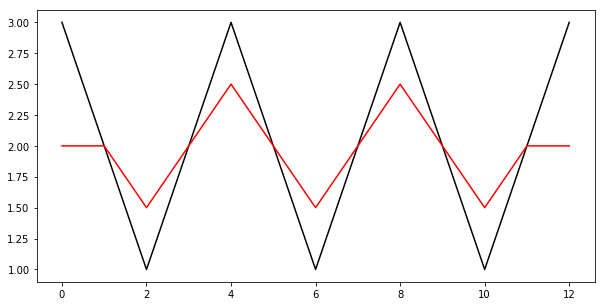

In [11]:
ts02 = SSA_group(A, U, V, len(ts), [0, 2])
print(ts02)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts02, 'r')
plt.show()

[ 0.99475095  0.16888858 -0.83242368 -0.16355599  0.83775627  0.16888858
 -0.83242368 -0.16355599  0.83775627  0.16888858 -0.83242368  0.16888858
  0.99475095]


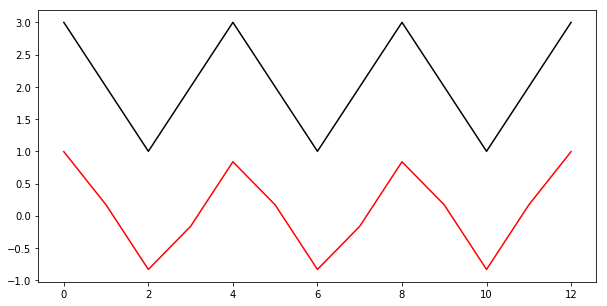

In [12]:
ts12 = SSA_group(A, U, V, len(ts), [1, 2])
print(ts12)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts12, 'r')
plt.show()

## Применение SSA к ряду из двух периодик с шумом

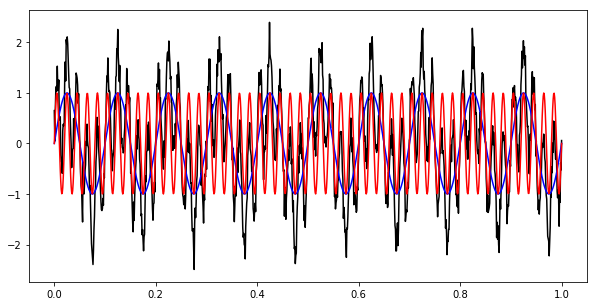

In [13]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50
F=np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)+0.2*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

### Разложение

In [14]:
A21, U21, V21 = SSA_modes(F, 21) # его разложение с длиной окна = 21
print("Собственные числа:\n", A21, '\n') # собственные числа
print("Собственные вектора:\n", U21, '\n') # собственные вектора
print("Траекторные вектора:\n", V21, '\n') # траекторные вектора

Собственные числа:
 [9387.24169787 6027.14249814 5440.85585348  516.142889     54.08456841
   48.20157176   47.52219256   44.42069708   43.50664594   43.24135746
   42.31359731   41.91161567   41.52499643   40.10058083   39.25542713
   37.53760802   37.18630597   34.25466709   34.06345861   33.32568893
   32.3333971 ] 

Собственные вектора:
 [[-1.84074510e-01 -8.41867125e-02  3.13255926e-01 -5.11602022e-01
   1.41341066e-01 -2.42476964e-01  2.60997368e-02 -3.80208605e-01
   1.80019288e-01  1.90167045e-01  1.22896080e-03 -1.25094708e-01
   3.05278638e-01 -6.86622526e-02  2.41711717e-01 -1.97062867e-02
  -1.63700634e-01  1.40405544e-01 -3.52840070e-02 -2.07743059e-01
  -2.08072752e-01]
 [-1.92357319e-01 -1.57620944e-01  2.92659648e-01 -3.44835771e-01
  -1.67030436e-01 -2.61701799e-02 -2.22315676e-01  5.18613851e-01
  -7.94941792e-02  8.91765701e-03 -2.74256427e-01  6.25236919e-02
   2.19352845e-01  1.10642647e-02 -1.47424974e-01 -2.05799652e-01
   1.36832192e-01 -1.47695211e-01 -6.214209

### Группировка по компонентам (длина окна 21)

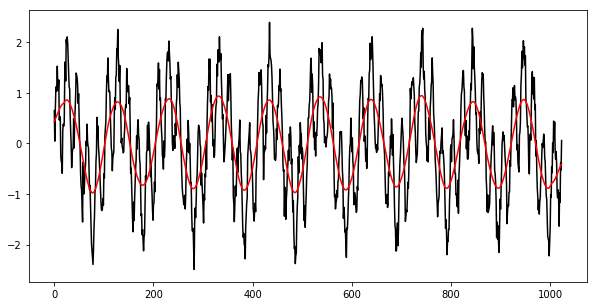

In [15]:
F0_21 = SSA_group(A21, U21, V21, len(F), [0])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F0_21, 'r') 
plt.show()

[ 1.00000000e+00  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01 -2.92770099e-16
  1.00000000e+00]


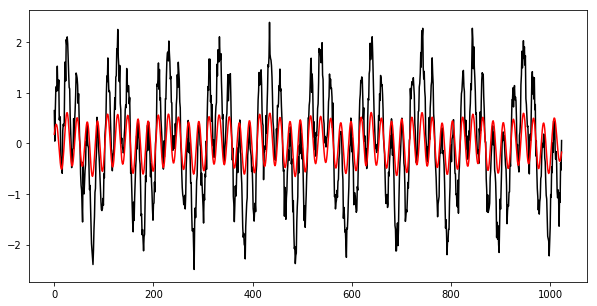

In [16]:
F1_21 = SSA_group(A21, U21, V21, len(F), [1])
print(ts1)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F1_21, 'r')
plt.show()

[-0.00524905  0.16888858 -0.33242368 -0.16355599  0.33775627  0.16888858
 -0.33242368 -0.16355599  0.33775627  0.16888858 -0.33242368  0.16888858
 -0.00524905]


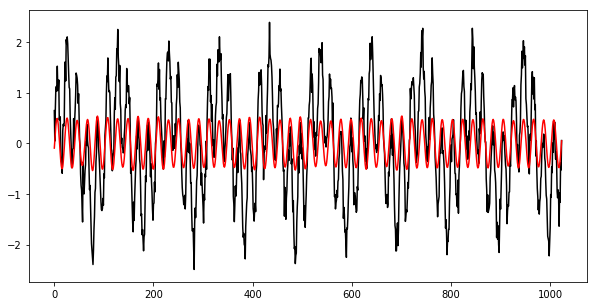

In [17]:
F2_21 = SSA_group(A21, U21, V21, len(F), [2])
print(ts2)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F2_21, 'r') 
plt.show()

[ 0.99475095  0.16888858 -0.83242368 -0.16355599  0.83775627  0.16888858
 -0.83242368 -0.16355599  0.83775627  0.16888858 -0.83242368  0.16888858
  0.99475095]


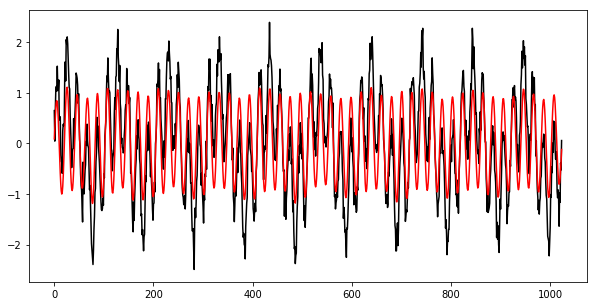

In [18]:
F12_21 = SSA_group(A21, U21, V21, len(F), [1, 2])
print(ts12)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F12_21, 'r')
plt.show()

### Результаты

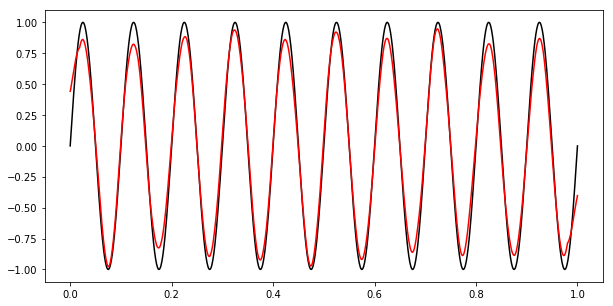

In [19]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f1*t), 'k')
plt.plot(t, F0_21, 'r')
plt.show()

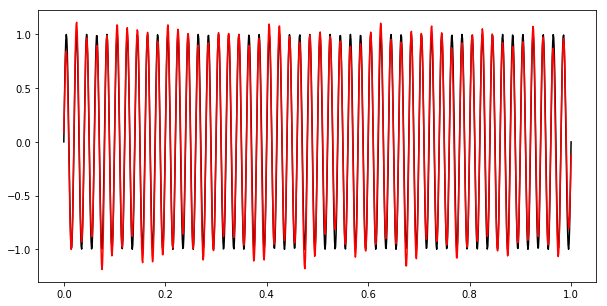

In [20]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f2*t), 'k')
plt.plot(t, F12_21, 'r')
plt.show()

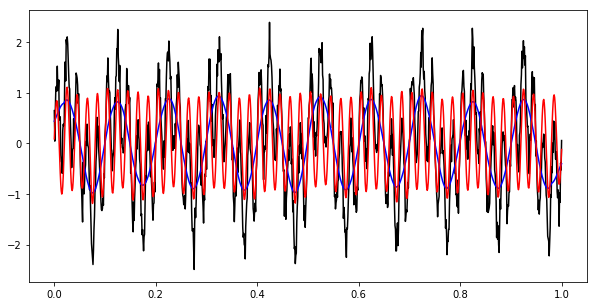

In [21]:
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, F0_21, 'b')
plt.plot(t, F12_21, 'r')
plt.show()

## Применение SSA к сильно зашумленному ряду

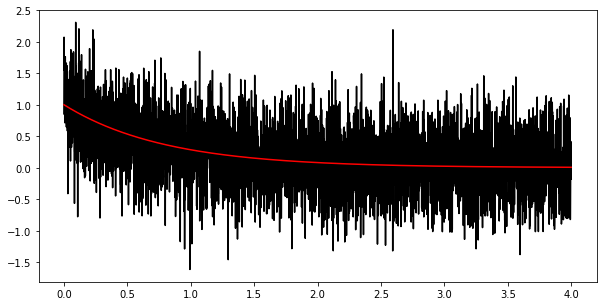

In [22]:
t = np.linspace(0,4,4096)
F = np.exp(-0.4*np.pi*t) + 0.5*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.exp(-0.4*np.pi*t), 'r')
plt.show()

### Разложение

In [23]:
A1000, U1000, V1000 = SSA_modes(F,1000) # его разложение с длиной окна = 1000
print("Собственные числа:\n", A1000, '\n') # собственные числа
print("Собственные вектора:\n", U1000, '\n') # собственные вектора
print("Траекторные вектора:\n", V1000, '\n') # траекторные вектора

Собственные числа:
 [1.39276671e+05 2.16283512e+03 2.15749275e+03 2.08886788e+03
 2.07102294e+03 2.00353264e+03 2.00308678e+03 1.98401319e+03
 1.97328771e+03 1.94412143e+03 1.94376727e+03 1.90857161e+03
 1.90697125e+03 1.89268358e+03 1.89244209e+03 1.85651610e+03
 1.85625231e+03 1.82135230e+03 1.81975359e+03 1.81319593e+03
 1.80961758e+03 1.78897604e+03 1.75904593e+03 1.75593387e+03
 1.73710698e+03 1.73444204e+03 1.73170481e+03 1.73037379e+03
 1.72357765e+03 1.72255193e+03 1.71980293e+03 1.71026542e+03
 1.70976665e+03 1.70795522e+03 1.69367611e+03 1.68940964e+03
 1.68703226e+03 1.68565230e+03 1.67843206e+03 1.67781012e+03
 1.65982181e+03 1.65841696e+03 1.64389892e+03 1.64167569e+03
 1.62551118e+03 1.62420441e+03 1.61584207e+03 1.61108864e+03
 1.59351009e+03 1.58926419e+03 1.58433997e+03 1.58329862e+03
 1.58059884e+03 1.56810198e+03 1.55449608e+03 1.55404224e+03
 1.53499854e+03 1.52186968e+03 1.51752425e+03 1.51194473e+03
 1.50999946e+03 1.49141103e+03 1.49065332e+03 1.48630257e+03
 1.4

### Группировка по компонентам (длина окна 1000)

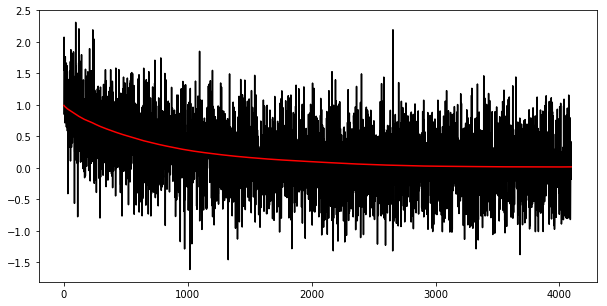

In [24]:
F0_1000 = SSA_group(A1000, U1000, V1000, len(F), [0])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F0_1000, 'r') 
plt.show()

### Результаты

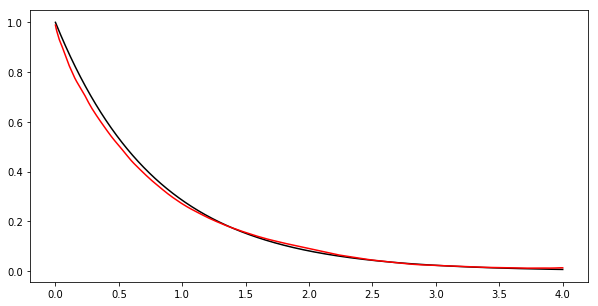

In [25]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.exp(-0.4*np.pi*t), 'k')
plt.plot(t, F0_1000, 'r') 
plt.show()

## Применение SSA к ряду из четырех гармоник с шумом

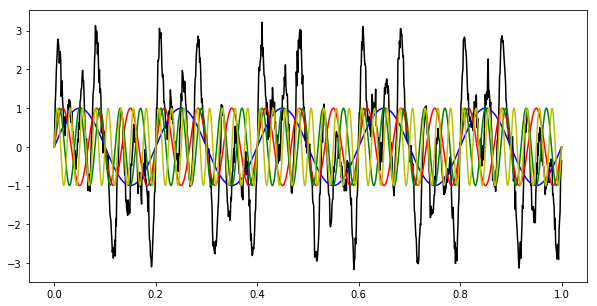

In [26]:
t = np.linspace(0, 1, 1024)
f1 = 5
f2 = 15
f3 = 25
f4 = 40
F=np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)+np.sin(2*np.pi*f3*t)+np.sin(2*np.pi*f4*t)+0.2*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.plot(t, np.sin(2*np.pi*f3*t), 'g')
plt.plot(t, np.sin(2*np.pi*f4*t), 'y')
plt.show()

### Разложение

In [27]:
A57, U57, V57 = SSA_modes(F, 57) # его разложение с длиной окна = 57
print("Собственные числа:\n", A57, '\n') # собственные числа
print("Собственные вектора:\n", U57, '\n') # собственные вектора
print("Траекторные вектора:\n", V57, '\n') # траекторные вектора

Собственные числа:
 [2.52616064e+04 2.33344089e+04 2.13561496e+04 1.62475148e+04
 1.56004468e+04 6.50987991e+03 4.37942289e+02 6.68761370e+01
 6.59159381e+01 5.54523962e+01 5.53749177e+01 5.13413538e+01
 5.11159289e+01 5.08067222e+01 5.07074243e+01 4.92806154e+01
 4.77272502e+01 4.76472511e+01 4.71888862e+01 4.68004852e+01
 4.66635862e+01 4.62050143e+01 4.60937994e+01 4.57618129e+01
 4.54566785e+01 4.42962033e+01 4.39310323e+01 4.25591697e+01
 4.22716056e+01 4.19019650e+01 4.15931805e+01 4.10311338e+01
 4.07067007e+01 4.00562740e+01 3.99980737e+01 3.94327450e+01
 3.94193333e+01 3.92500424e+01 3.85491457e+01 3.80521769e+01
 3.73034369e+01 3.70603901e+01 3.66786511e+01 3.66143089e+01
 3.63262886e+01 3.60832856e+01 3.45331686e+01 3.41627897e+01
 3.24933471e+01 3.07014180e+01 3.04531581e+01 3.00474557e+01
 2.66117915e+01 2.64548049e+01 2.52547905e+01 2.51233462e+01
 2.44475621e+01] 

Собственные вектора:
 [[-0.0715178  -0.04172184 -0.15088305 ...  0.00811916 -0.02516
   0.18400992]
 [-0.08

### Группировка по компонентам

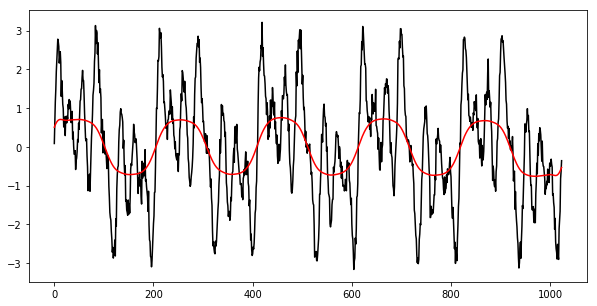

In [28]:
F0_57 = SSA_group(A57, U57, V57, len(F), [0])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F0_57, 'r') 
plt.show()

In [29]:
A60, U60, V60 = SSA_modes(F, 60) # его разложение с длиной окна = 60
print("Собственные числа:\n", A60, '\n') # собственные числа
print("Собственные вектора:\n", U60, '\n') # собственные вектора
print("Траекторные вектора:\n", V60, '\n') # траекторные вектора

Собственные числа:
 [2.54889884e+04 2.33305202e+04 2.24185525e+04 1.62700466e+04
 1.60686162e+04 9.77135123e+03 8.83078300e+02 6.71708059e+01
 6.70131964e+01 5.86234008e+01 5.53920338e+01 5.52453441e+01
 5.15431887e+01 5.12901404e+01 5.08479441e+01 5.04905993e+01
 4.90036430e+01 4.85760975e+01 4.84096483e+01 4.70211731e+01
 4.68370746e+01 4.63347375e+01 4.61197946e+01 4.60125972e+01
 4.58695695e+01 4.51575754e+01 4.41948969e+01 4.36080673e+01
 4.24713688e+01 4.24162875e+01 4.22733960e+01 4.16555325e+01
 4.08796537e+01 4.05110199e+01 4.03552164e+01 4.02621796e+01
 3.97903627e+01 3.97685080e+01 3.89812864e+01 3.86922849e+01
 3.84304331e+01 3.75717478e+01 3.73447948e+01 3.71047058e+01
 3.67906829e+01 3.65404724e+01 3.63286767e+01 3.58475095e+01
 3.55214758e+01 3.37935389e+01 3.37400337e+01 3.05215277e+01
 3.02225802e+01 2.89919356e+01 2.80356208e+01 2.63342267e+01
 2.61239970e+01 2.45634839e+01 2.44996657e+01 2.36532768e+01] 

Собственные вектора:
 [[-0.08164988  0.02863258 -0.12080852 ..

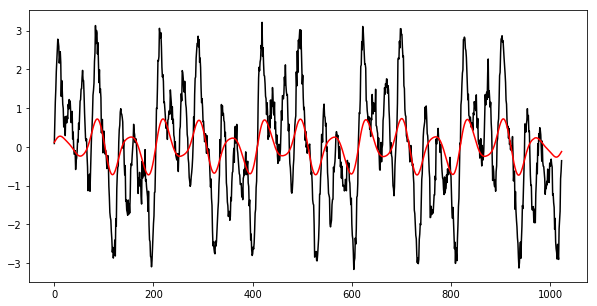

In [30]:
F1_60 = SSA_group(A60, U60, V60, len(F), [1])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F1_60, 'r') 
plt.show()

In [31]:
A65, U65, V65 = SSA_modes(F, 65) # его разложение с длиной окна = 65
print("Собственные числа:\n", A65, '\n') # собственные числа
print("Собственные вектора:\n", U65, '\n') # собственные вектора
print("Траекторные вектора:\n", V65, '\n') # траекторные вектора

Собственные числа:
 [2.57569013e+04 2.32920034e+04 2.31597592e+04 1.63790513e+04
 1.61937882e+04 1.59037390e+04 2.57003957e+03 1.00704674e+02
 6.85348098e+01 6.76980041e+01 5.64505423e+01 5.59246411e+01
 5.22868460e+01 5.21780678e+01 5.20481325e+01 5.18624012e+01
 5.17597541e+01 5.05804373e+01 4.93437427e+01 4.92052040e+01
 4.85517380e+01 4.75052931e+01 4.68958620e+01 4.66300805e+01
 4.60049408e+01 4.59591810e+01 4.49931274e+01 4.49526266e+01
 4.44105810e+01 4.40466732e+01 4.27405877e+01 4.25136701e+01
 4.15388069e+01 4.07933763e+01 4.05991027e+01 4.04907390e+01
 4.02935436e+01 4.01767197e+01 3.98331774e+01 3.97507804e+01
 3.91108592e+01 3.90184259e+01 3.80127877e+01 3.77474474e+01
 3.71044969e+01 3.69394472e+01 3.66493150e+01 3.65131935e+01
 3.63707874e+01 3.60951306e+01 3.52749607e+01 3.51573065e+01
 3.42064240e+01 3.34982122e+01 3.34774299e+01 3.30552586e+01
 2.81166075e+01 2.80368263e+01 2.70596087e+01 2.60175737e+01
 2.54720021e+01 2.51875535e+01 2.38743664e+01 2.36984388e+01
 2.2

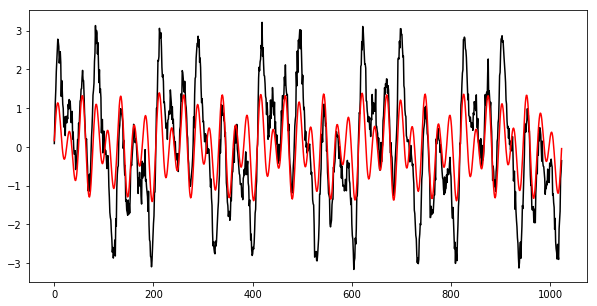

In [50]:
F3_65 = SSA_group(A65, U65, V65, len(F), [3,4,5])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F3_65, 'r') 
plt.show()

In [33]:
A75, U75, V75 = SSA_modes(F, 75) # его разложение с длиной окна = 75
print("Собственные числа:\n", A75, '\n') # собственные числа
print("Собственные вектора:\n", U75, '\n') # собственные вектора
print("Траекторные вектора:\n", V75, '\n') # траекторные вектора

Собственные числа:
 [2.54104735e+04 2.42593333e+04 2.32491780e+04 2.32266921e+04
 1.71457689e+04 1.62747437e+04 1.10360310e+04 8.32095630e+02
 7.04710905e+01 7.03242351e+01 5.77039936e+01 5.74208642e+01
 5.40081247e+01 5.36861047e+01 5.23618088e+01 5.21109825e+01
 5.19990784e+01 5.19698675e+01 5.11960998e+01 5.10154209e+01
 5.08222082e+01 5.07786170e+01 4.89800875e+01 4.89702623e+01
 4.80589557e+01 4.78436776e+01 4.71745001e+01 4.63601669e+01
 4.54874241e+01 4.53556709e+01 4.53441146e+01 4.51582740e+01
 4.39750950e+01 4.34103826e+01 4.30033484e+01 4.28678193e+01
 4.14127456e+01 4.12131428e+01 4.07640744e+01 4.07360588e+01
 4.00321011e+01 3.98518119e+01 3.93102538e+01 3.92184771e+01
 3.82739330e+01 3.81647631e+01 3.77658257e+01 3.73420484e+01
 3.67932868e+01 3.65939104e+01 3.65437397e+01 3.61436805e+01
 3.59567360e+01 3.56778338e+01 3.52474459e+01 3.49933243e+01
 3.44801902e+01 3.39160558e+01 3.37573132e+01 3.34088777e+01
 3.31898278e+01 3.31540573e+01 3.19409764e+01 3.09315055e+01
 3.0

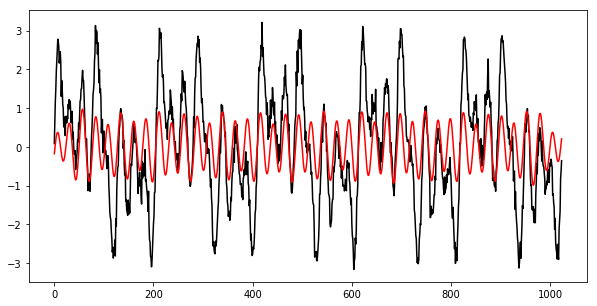

In [48]:
F4_75 = SSA_group(A75, U75, V75, len(F), [4,5])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F4_75, 'r') 
plt.show()

### Результаты

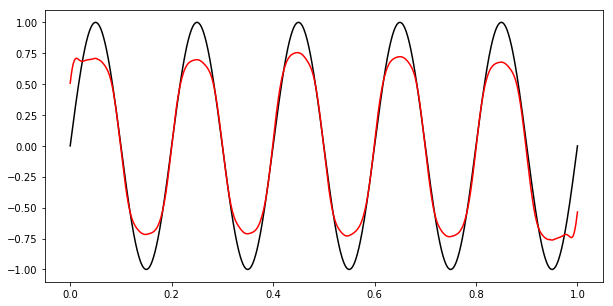

In [35]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f1*t), 'k')
plt.plot(t, F0_57, 'r')
plt.show()

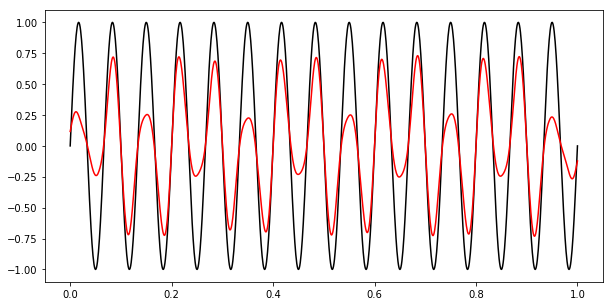

In [36]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f2*t), 'k')
plt.plot(t, F1_60, 'r') 
plt.show()

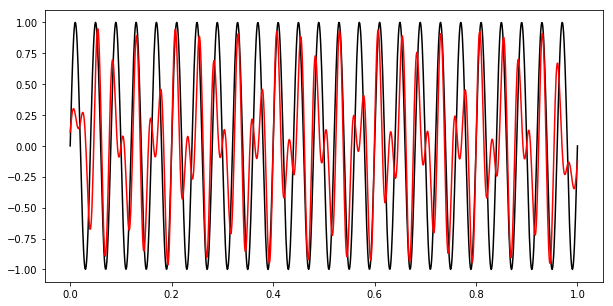

In [37]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f3*t), 'k')
plt.plot(t, F3_65, 'r')
plt.show()

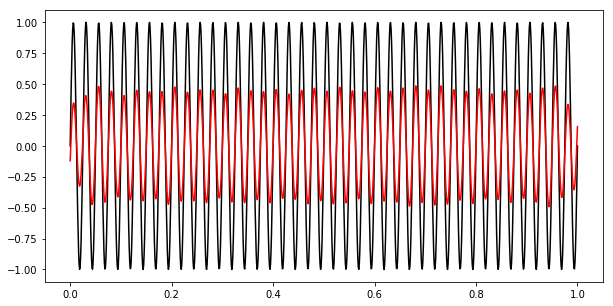

In [38]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f4*t), 'k')
plt.plot(t, F4_75, 'r')
plt.show()

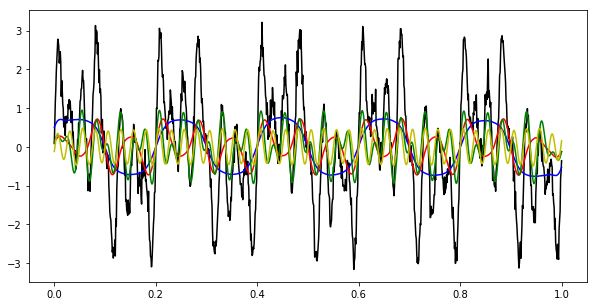

In [39]:
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, F0_57, 'b')
plt.plot(t, F1_60, 'r')
plt.plot(t, F3_65, 'g')
plt.plot(t, F4_75, 'y')
plt.show()

## Применение SSA к ряду с изломом частоты

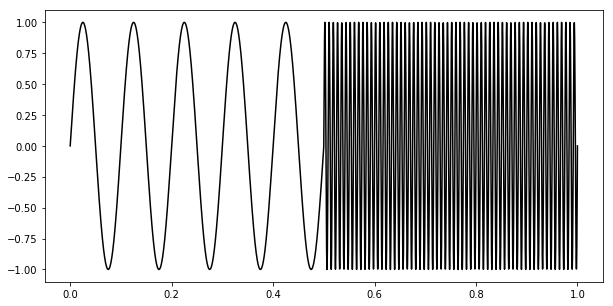

In [40]:
t = np.linspace(0, 1, 4096)
x2 = np.zeros(4096)
for i in range(0, len(t)//2):
    x2[i] = np.sin(2*np.pi*10*t[i])
for i in range(len(t)//2, len(t)):
    x2[i] = np.sin(2*np.pi*120*t[i])
plt.figure(figsize = (10, 5))
plt.plot(t, x2, 'k')
plt.show()

### Разложение

In [41]:
A33, U33, V33 = SSA_modes(x2, 33) # его разложение с длиной окна = 33
print("Собственные числа:\n", A33, '\n') # собственные числа
print("Собственные вектора:\n", U33, '\n') # собственные вектора
print("Траекторные вектора:\n", V33, '\n') # траекторные вектора

Собственные числа:
 [3.31947216e+04 1.78119132e+04 1.60274390e+04 2.50377101e+02
 5.37835401e+00 1.73519935e+00 5.18877253e-01 2.58879760e-01
 1.24848716e-01 7.47034442e-02 4.37810023e-02 2.89193526e-02
 1.88292588e-02 1.32200069e-02 9.17786001e-03 6.70398409e-03
 4.84855693e-03 3.63249849e-03 2.69457112e-03 2.04760942e-03
 1.53867666e-03 1.17366178e-03 8.82719996e-04 6.67838822e-04
 4.95430038e-04 3.65560436e-04 2.61597250e-04 1.82779407e-04
 1.20853621e-04 7.48230121e-05 4.07707457e-05 1.78183101e-05
 4.38685462e-06] 

Собственные вектора:
 [[-0.15599454  0.04986706  0.26557964 ... -0.01798356 -0.01132843
  -0.00593123]
 [-0.15732714  0.0908337   0.25376582 ...  0.07131004  0.04670435
   0.02400296]
 [-0.15905686  0.12907809  0.23403257 ... -0.13794628 -0.09391031
  -0.04832263]
 ...
 [-0.15926854 -0.1400487   0.22855981 ... -0.13794548  0.09390969
  -0.0483223 ]
 [-0.15739    -0.10258795  0.25048008 ...  0.07130883 -0.04670354
   0.02400254]
 [-0.15590169 -0.0619616   0.26458966 ...

### Группировка по компонентам (длина окна 33)

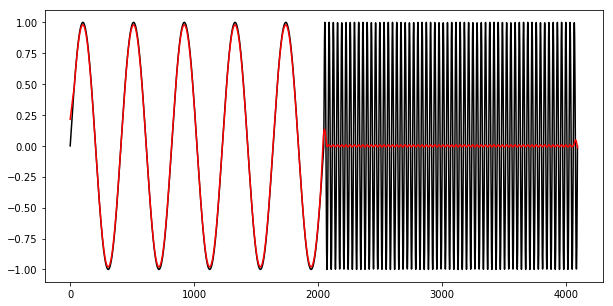

In [42]:
F0_33 = SSA_group(A33, U33, V33, len(x2), [0])

plt.figure(figsize = (10, 5))
plt.plot(x2, 'k')
plt.plot(F0_33, 'r') 
plt.show()

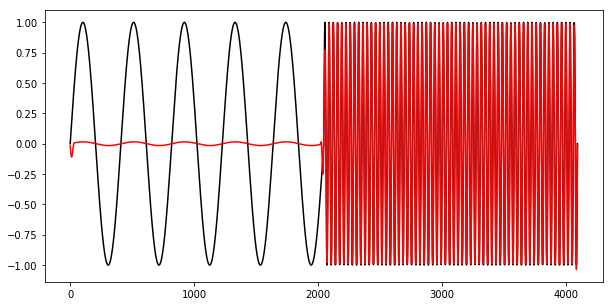

In [43]:
F12_33 = SSA_group(A33, U33, V33, len(x2), [1, 2])

plt.figure(figsize = (10, 5))
plt.plot(x2, 'k')
plt.plot(F12_33, 'r') 
plt.show()

## Применение SSA к ряду из файла

In [44]:
file = h5py.File('lab5.mat','r')
data = file.get('EEG')
eeg = np.array(data).T

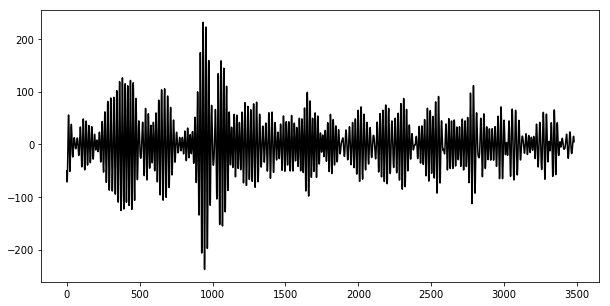

In [45]:
plt.figure(figsize = (10, 5))
plt.plot(eeg, 'k')
plt.show()

### Разложение

In [46]:
A2000, U2000, V2000 = SSA_modes(eeg, 2000) # его разложение с длиной окна = 2000
print("Собственные числа:\n", A2000, '\n') # собственные числа
print("Собственные вектора:\n", U2000, '\n') # собственные вектора
print("Траекторные вектора:\n", V2000, '\n') # траекторные вектора

Собственные числа:
 [6.04699405e+08 6.02332190e+08 4.94156153e+08 ... 3.06824143e-08
 1.75869412e-08 7.22283117e-09] 

Собственные вектора:
 [[-0.02939991 -0.01933127  0.01359299 ... -0.00488269  0.0343171
   0.04840309]
 [-0.03415579 -0.00999518  0.02048404 ... -0.01783793 -0.01313505
  -0.03094931]
 [-0.03578804  0.00039214  0.02484666 ...  0.02697604  0.00148227
   0.02135535]
 ...
 [ 0.01249573  0.00686028  0.00043436 ... -0.01601224  0.0102944
   0.01704154]
 [ 0.01387041  0.00282404  0.00258031 ... -0.00749442  0.0011225
   0.0057575 ]
 [ 0.01393568 -0.00143924  0.00447146 ...  0.00317294 -0.00838346
  -0.00548163]] 

Траекторные вектора:
 [[ 6.34566265e+02 -5.08378406e+02  3.19480353e+02 ... -7.37411199e-09
  -5.34127622e-08  4.40211938e-08]
 [ 7.66402256e+02 -3.06990833e+02  5.39409313e+02 ... -5.20843813e-09
   1.35126068e-07 -1.28040831e-07]
 [ 8.28941350e+02 -7.36983597e+01  6.95251976e+02 ...  1.54399599e-07
  -7.88144716e-08  1.15064523e-07]
 ...
 [ 1.19524953e+02  1.34842

### Группировка по компонентам (длина окна 2000)

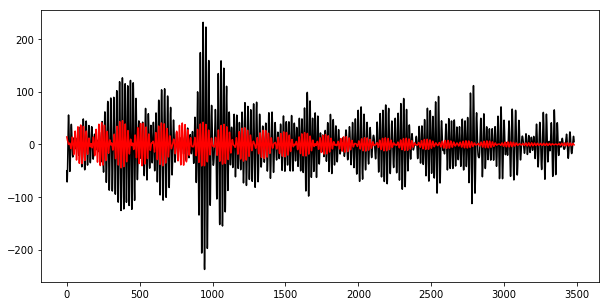

In [47]:
F12_2000 = SSA_group(A2000, U2000, V2000, len(eeg), [1,2])

plt.figure(figsize = (10, 5))
plt.plot(eeg, 'k')
plt.plot(F12_2000, 'r') 
plt.show()